<a href="https://colab.research.google.com/github/Dharti-Raval/Visualizing-and-Classifying-Groups-Abstract-Algebra-/blob/main/Visualizing_and_Classifying_Groups_(Abstract_Algebra).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import itertools
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pprint import pprint

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [2]:
class FiniteGroup:
    def __init__(self, name, elements, op, identity):
        self.name = name
        self.elements = list(elements)
        self.op = op
        self.e = identity
        self.order = len(self.elements)
        self.index = {x:i for i,x in enumerate(self.elements)}
        # compute inverses
        self._inv = {}
        for a in self.elements:
            for b in self.elements:
                if op(a,b) == identity and op(b,a) == identity:
                    self._inv[a] = b
                    break

    def multiply(self, a, b):
        return self.op(a,b)

    def inverse(self, a):
        return self._inv.get(a)

    def cayley_table(self):
        n = self.order
        mat = [[self.op(self.elements[i], self.elements[j]) for j in range(n)] for i in range(n)]
        return mat

    def is_abelian(self):
        for a in self.elements:
            for b in self.elements:
                if self.op(a,b) != self.op(b,a):
                    return False
        return True

    def center(self):
        return [a for a in self.elements if all(self.op(a,b)==self.op(b,a) for b in self.elements)]

    def conjugacy_classes(self):
        seen = set()
        classes = []
        for a in self.elements:
            if a in seen:
                continue
            cls = set(self.op(g, self.op(a, self.inverse(g))) for g in self.elements)
            classes.append(sorted(cls, key=lambda x: str(x)))
            seen |= cls
        return classes

    def element_order(self, a):
        cur = self.e
        for n in range(1, self.order+1):
            cur = self.op(cur, a)
            if cur == self.e:
                return n
        return None

    def element_orders(self):
        return {a: self.element_order(a) for a in self.elements}

    def powers_of(self, a):
        cur = self.e
        seen = {cur}
        while True:
            cur = self.op(cur, a)
            if cur in seen:
                break
            seen.add(cur)
        return sorted(seen, key=lambda x: str(x))

    def is_cyclic(self):
        for a in self.elements:
            if len(self.powers_of(a)) == self.order:
                return True
        return False

    def all_subgroups(self, limit=16):
        if self.order > limit:
            return None
        subs = set()
        for r in range(1, len(self.elements)+1):
            for gens in itertools.combinations(self.elements, r):
                S = {self.e}
                changed = True
                while changed:
                    changed = False
                    for x in list(S):
                        for g in gens:
                            a = self.op(x,g)
                            b = self.op(g,x)
                            if a not in S:
                                S.add(a); changed = True
                            if b not in S:
                                S.add(b); changed = True
                subs.add(tuple(sorted(S, key=lambda x: str(x))))
        return [list(s) for s in subs]

    def normal_subgroups(self):
        subs = self.all_subgroups()
        if subs is None:
            return None
        normals = []
        for H in subs:
            Hset = set(H)
            ok = True
            for g in self.elements:
                for h in H:
                    conj = self.op(g, self.op(h, self.inverse(g)))
                    if conj not in Hset:
                        ok = False
                        break
                if not ok:
                    break
            if ok:
                normals.append(H)
        return normals

    def commutator(self, a, b):
        ainv = self.inverse(a); binv = self.inverse(b)
        return self.op(self.op(ainv, binv), self.op(a, b))

    def commutator_subgroup(self):
        gens = set(self.commutator(a,b) for a in self.elements for b in self.elements)
        S = {self.e}
        changed = True
        while changed:
            changed = False
            for x in list(S):
                for g in gens:
                    a = self.op(x,g); b = self.op(g,x)
                    if a not in S:
                        S.add(a); changed = True
                    if b not in S:
                        S.add(b); changed = True
        return sorted(S, key=lambda x: str(x))

    def derived_series(self, max_iter=10):
        series = [sorted(self.elements, key=lambda x: str(x))]
        current_set = set(self.elements)
        for _ in range(max_iter):
            comm = set(self.commutator_subgroup())
            series.append(sorted(comm, key=lambda x: str(x)))
            if comm == {self.e} or comm == current_set:
                break
            current_set = comm
        return series

    def is_solvable(self):
        series = self.derived_series()
        return series and set(series[-1]) == {self.e}

    def cayley_graph(self, generators):
        G = nx.Graph()
        for v in self.elements:
            G.add_node(v)
        for a in self.elements:
            for g in generators:
                b = self.op(a,g)
                G.add_edge(a,b)
        return G


In [3]:
# cyclic C_n (represented as integers 0..n-1 under addition mod n)
def make_Cn(n):
    elems = list(range(n))
    def op(a,b): return (a + b) % n
    return FiniteGroup(f"C{n}", elems, op, 0)

# symmetric S_n using permutation tuples
def compose_perm(p, q):
    return tuple(p[i-1] for i in q)  # q then p; using 1-based elements in representation

def make_Sn(n):
    perms = [tuple(p) for p in itertools.permutations(range(1,n+1))]
    def op(a,b): return compose_perm(a,b)
    return FiniteGroup(f"S{n}", perms, op, tuple(range(1,n+1)))

# dihedral D_n as permutations of n points: rotation r and reflection s
def make_Dn(n):
    # represent permutations as tuples of images 0..n-1
    def rot(k):
        return tuple((i + k) % n for i in range(n))
    def refl(k):
        return tuple((( -i ) % n + k) % n for i in range(n))
    elems = [rot(k) for k in range(n)] + [refl(k) for k in range(n)]
    elems = list(dict.fromkeys(elems))
    def op(a,b): return tuple(a[b[i]] for i in range(n))
    return FiniteGroup(f"D{n}", elems, op, tuple(range(n)))

# quaternion Q8 with explicit multiplication
def make_Q8():
    elems = ['1','-1','i','-i','j','-j','k','-k']
    def mul(a,b):
        sign = 1
        if a.startswith('-'): sign *= -1; a = a[1:]
        if b.startswith('-'): sign *= -1; b = b[1:]
        table = {
            ('1','1'):'1', ('1','i'):'i', ('1','j'):'j', ('1','k'):'k',
            ('i','1'):'i', ('j','1'):'j', ('k','1'):'k',
            ('i','i'):'-1', ('j','j'):'-1', ('k','k'):'-1',
            ('i','j'):'k', ('j','k'):'i', ('k','i'):'j',
            ('j','i'):'-k', ('k','j'):'-i', ('i','k'):'-j'
        }
        out = table[(a,b)]
        if out.startswith('-'):
            sign *= -1
            out = out[1:]
        return ('' if sign==1 else '-') + out
    return FiniteGroup("Q8", elems, mul, '1')

# direct product G x H
def direct_product(G, H):
    elems = [(a,b) for a in G.elements for b in H.elements]
    def op(x,y):
        return (G.op(x[0], y[0]), H.op(x[1], y[1]))
    return FiniteGroup(f"{G.name}x{H.name}", elems, op, (G.e, H.e))


In [4]:
groups = []

# cyclic groups
for n in range(1,11):            # C1 .. C10
    groups.append(make_Cn(n))

# dihedral groups D3..D8
for n in range(3,9):
    groups.append(make_Dn(n))

# symmetric S2, S3, S4
for n in [2,3,4]:
    groups.append(make_Sn(n))

# quaternion
groups.append(make_Q8())

# direct products: C2xC2 (Klein 4), C2xC3, C3xC3, C2xC4
groups.append(direct_product(make_Cn(2), make_Cn(2)))
groups.append(direct_product(make_Cn(2), make_Cn(3)))
groups.append(direct_product(make_Cn(3), make_Cn(3)))
groups.append(direct_product(make_Cn(2), make_Cn(4)))

# Deduplicate by name
byname = {g.name: g for g in groups}
groups = [byname[name] for name in sorted(byname.keys(), key=lambda s: (len(s), s))]

len(groups)


24

In [5]:
def cayley_table_matrix(group):
    elems = group.elements
    idx = {e:i for i,e in enumerate(elems)}
    n = group.order
    mat = np.zeros((n,n), dtype=int)
    for i,a in enumerate(elems):
        for j,b in enumerate(elems):
            prod = group.op(a,b)
            mat[i,j] = idx[prod]
    return mat, elems

def plot_cayley_table(group, figsize=(6,6)):
    mat, elems = cayley_table_matrix(group)
    plt.figure(figsize=figsize)
    plt.imshow(mat, interpolation='nearest', cmap='viridis')
    ticks = list(range(len(elems)))
    labels = [str(e) for e in elems]
    plt.xticks(ticks, labels, rotation=90, fontsize=8)
    plt.yticks(ticks, labels, fontsize=8)
    plt.title(f"Cayley table: {group.name} (n={group.order})")
    plt.colorbar(label='element index')
    plt.show()

def default_generators(group):
    if group.name.startswith("C") and all(isinstance(x,int) for x in group.elements):
        return [1 % group.order]
    if group.name.startswith("D"):
        orders = group.element_orders()
        max_ord = max(orders.values())
        rot = next(a for a,o in orders.items() if o==max_ord)
        refl = next((a for a,o in orders.items() if o==2 and a!=group.e), None)
        gens = [rot] + ([refl] if refl else [])
        return gens
    if group.name.startswith("S"):
        orders = group.element_orders()
        n = int(group.name[1:])
        cycle = next((a for a,o in orders.items() if o==n), None)
        trans = next((a for a,o in orders.items() if o==2 and a!=group.e), None)
        gens = []
        if cycle: gens.append(cycle)
        if trans: gens.append(trans)
        return gens if gens else [group.elements[1]]
    if group.name == "Q8":
        return ['i','j']
    return [a for a in group.elements if a!=group.e][:2]

def plot_cayley_graph(group, generators=None, figsize=(6,6)):
    if generators is None:
        generators = default_generators(group)
    G = group.cayley_graph(generators)
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=False, node_size=250)
    for node, (x,y) in pos.items():
        plt.text(x, y, str(node), fontsize=8, ha='center', va='center')
    plt.title(f"Cayley graph: {group.name} — generators: {generators}")
    plt.axis('off')
    plt.show()


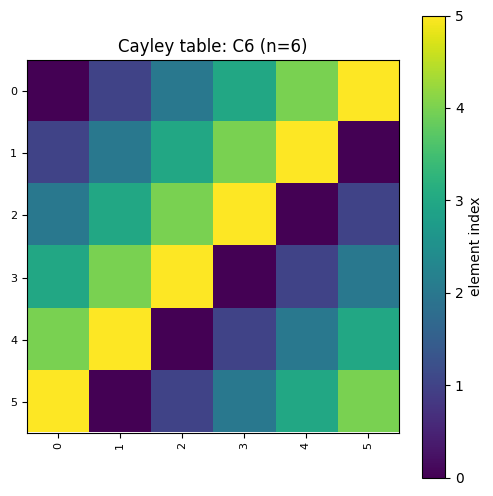

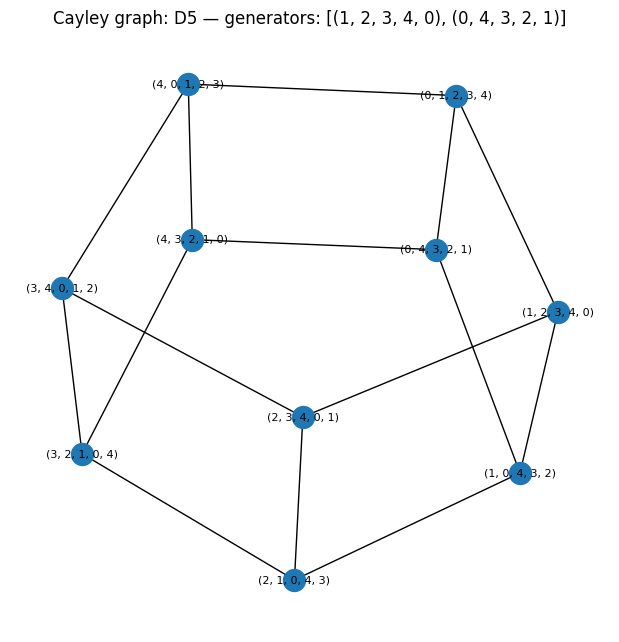

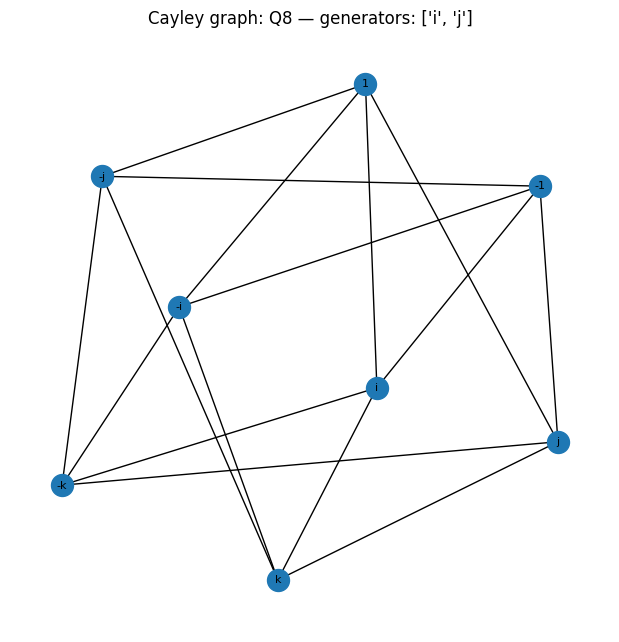

In [6]:
plot_cayley_table(next(g for g in groups if g.name=="C6"))
plot_cayley_graph(next(g for g in groups if g.name=="D5"))
plot_cayley_graph(next(g for g in groups if g.name=="Q8"))


In [7]:
def extract_features(group, max_order_feature=10):
    feat = {}
    feat['name'] = group.name
    feat['order'] = group.order
    feat['is_abelian'] = int(group.is_abelian())
    feat['is_cyclic'] = int(group.is_cyclic())
    feat['center_size'] = len(group.center())
    conj = group.conjugacy_classes()
    feat['n_conjugacy_classes'] = len(conj)
    orders_map = group.element_orders()
    counts = Counter(orders_map.values())
    for k in range(1, max_order_feature+1):
        feat[f'n_el_order_{k}'] = counts.get(k, 0)
    normals = group.normal_subgroups()
    feat['num_normal_subgroups'] = len(normals) if normals is not None else -1
    simple = group.is_simple() if hasattr(group, 'is_simple') else None
    feat['is_simple'] = int(simple) if isinstance(simple, bool) else -1
    feat['is_solvable'] = int(group.is_solvable())
    gens = default_generators(group)
    G = group.cayley_graph(gens)
    degs = [d for _,d in G.degree()]
    feat['avg_degree'] = float(np.mean(degs)) if degs else 0.0
    # Laplacian eigenvalues (first 6)
    try:
        L = nx.laplacian_matrix(G).todense()
        eigs = np.linalg.eigvalsh(np.array(L))
        eigs_sorted = sorted(eigs)
        for i in range(6):
            feat[f'lap_eig_{i+1}'] = float(eigs_sorted[i]) if i < len(eigs_sorted) else 0.0
    except:
        for i in range(6):
            feat[f'lap_eig_{i+1}'] = 0.0
    orders_list = list(orders_map.values())
    feat['mean_element_order'] = float(np.mean(orders_list)) if orders_list else 0.0
    feat['median_element_order'] = float(np.median(orders_list)) if orders_list else 0.0
    feat['std_element_order'] = float(np.std(orders_list)) if orders_list else 0.0
    return feat

dataset = [extract_features(g) for g in groups]
df = pd.DataFrame(dataset)
df = df.sort_values('order').reset_index(drop=True)
df.head(20)


,name,order,is_abelian,is_cyclic,center_size,n_conjugacy_classes,n_el_order_1,n_el_order_2,n_el_order_3,n_el_order_4,...,avg_degree,lap_eig_1,lap_eig_2,lap_eig_3,lap_eig_4,lap_eig_5,lap_eig_6,mean_element_order,median_element_order,std_element_order
0,C1,1,1,1,1,1,1,0,0,0,...,2.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000,1.0,0.000000
1,C2,2,1,1,2,2,1,1,0,0,...,1.0,0.000000e+00,2.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.500000,1.5,0.500000
2,S2,2,1,1,2,2,1,1,0,0,...,1.0,0.000000e+00,2.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.500000,1.5,0.500000
3,C3,3,1,1,3,3,1,0,2,0,...,2.0,-1.110223e-16,3.000000e+00,3.000000e+00,0.000000,0.000000,0.000000,2.333333,3.0,0.942809
4,C2xC2,4,1,0,4,4,1,3,0,0,...,2.0,-6.661338e-16,2.000000e+00,2.000000e+00,4.000000,0.000000,0.000000,1.750000,2.0,0.433013
5,C4,4,1,1,4,4,1,1,0,2,...,2.0,-8.586881e-16,2.000000e+00,2.000000e+00,4.000000,0.000000,0.000000,2.750000,3.0,1.299038
6,C5,5,1,1,5,5,1,0,0,0,...,2.0,2.775558e-17,1.381966e+00,1.381966e+00,3.618034,3.618034,0.000000,4.200000,5.0,1.600000
7,C6,6,1,1,6,6,1,1,2,0,...,2.0,-2.775558e-16,1.000000e+00,1.000000e+00,3.000000,3.000000,4.000000,3.500000,3.0,1.892969
8,S3,6,0,0,1,3,1,3,2,0,...,3.0,-1.400247e-15,2.000000e+00,3.000000e+00,3.000000,5.000000,5.000000,2.166667,2.0,0.687184
9,C2xC3,6,1,1,6,6,1,1,2,0,...,2.0,-1.110223e-16,-1.110223e-16,3.000000e+00,3.000000,3.000000,3.000000,3.500000,3.0,1.892969


In [8]:
def label_group_type(name):
    if name.startswith('C') and 'x' not in name:
        return 'cyclic'
    if name.startswith('D'):
        return 'dihedral'
    if name.startswith('S'):
        return 'symmetric'
    if name == 'Q8':
        return 'quaternion'
    if 'x' in name:
        return 'direct_product'
    return 'other'

df['group_type'] = df['name'].apply(label_group_type)
df['group_type'].value_counts()


,count
group_type,
cyclic,10
dihedral,6
direct_product,4
symmetric,3
quaternion,1


In [9]:
features = [c for c in df.columns if c.startswith('n_el_order_') or c.startswith('lap_eig_')] + \
           ['order','center_size','n_conjugacy_classes','avg_degree','mean_element_order','is_cyclic']

X = df[features].fillna(0)
y = df['is_abelian']

# If any class has <2 samples, do not stratify
y_counts = y.value_counts()
stratify_flag = True if y_counts.min() >= 2 else False

if stratify_flag:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred_lr))
print("Random Forest accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest classification report:\n", classification_report(y_test, y_pred_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))


Logistic Regression accuracy: 1.0
Random Forest accuracy: 1.0

Random Forest classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Confusion matrix:
 [[3 0]
 [0 5]]


In [10]:
from sklearn.utils.multiclass import unique_labels

# Prepare data for multiclass classification on 'group_type'
ym = df['group_type']
le = LabelEncoder()
ym_encoded = le.fit_transform(ym)

# Split data for multiclass classification
# Removed 'stratify' argument as some classes have only one member
X_train_mc, X_test_mc, ym_train, ym_test = train_test_split(X, ym_encoded, test_size=0.3, random_state=42)

# Train a RandomForestClassifier for multiclass
rf_mc = RandomForestClassifier(n_estimators=300, random_state=42)
rf_mc.fit(X_train_mc, ym_train)
ym_pred = rf_mc.predict(X_test_mc)

# Evaluate multiclass model safely
print("Multiclass accuracy:", accuracy_score(ym_test, ym_pred))

# Identify which classes are actually present in y_test/y_pred
labels_present = unique_labels(ym_test, ym_pred)
label_names_present = [le.classes_[i] for i in labels_present]

# Generate the classification report only for present labels
print(classification_report(ym_test, ym_pred,
                            labels=labels_present,
                            target_names=label_names_present, zero_division=0))

Multiclass accuracy: 0.5
                precision    recall  f1-score   support

        cyclic       0.75      0.60      0.67         5
      dihedral       0.50      1.00      0.67         1
direct_product       0.00      0.00      0.00         1
     symmetric       0.00      0.00      0.00         1

      accuracy                           0.50         8
     macro avg       0.31      0.40      0.33         8
  weighted avg       0.53      0.50      0.50         8



In [11]:
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
imp.head(15)


,0
n_el_order_2,0.162949
avg_degree,0.156508
center_size,0.138246
order,0.074204
is_cyclic,0.073928
lap_eig_5,0.070144
lap_eig_6,0.049624
n_conjugacy_classes,0.046520
mean_element_order,0.046005
lap_eig_3,0.042916


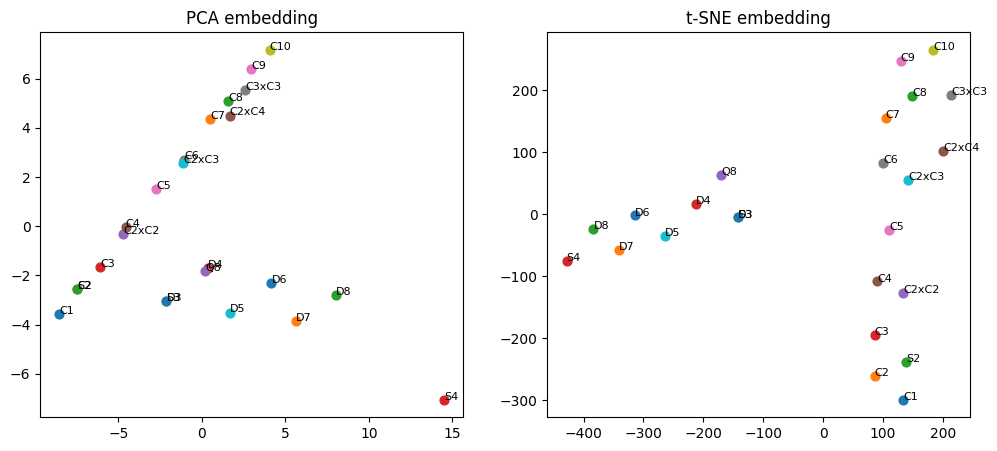

In [12]:
embed_cols = ['order','center_size','n_conjugacy_classes','avg_degree','mean_element_order'] + [f'lap_eig_{i}' for i in range(1,7)]
E = df[embed_cols].fillna(0).values

pca = PCA(n_components=2, random_state=42)
E_pca = pca.fit_transform(E)

tsne = TSNE(n_components=2, random_state=42, perplexity=6, init='pca')
E_tsne = tsne.fit_transform(E)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for i, label in enumerate(df['name']):
    plt.scatter(E_pca[i,0], E_pca[i,1], s=40)
    plt.text(E_pca[i,0]+0.01, E_pca[i,1]+0.01, label, fontsize=8)
plt.title("PCA embedding")

plt.subplot(1,2,2)
for i, label in enumerate(df['name']):
    plt.scatter(E_tsne[i,0], E_tsne[i,1], s=40)
    plt.text(E_tsne[i,0]+0.01, E_tsne[i,1]+0.01, label, fontsize=8)
plt.title("t-SNE embedding")
plt.show()
